In [1]:
from matplotlib import pyplot as plt
import numpy as np
import random
from IPython import display

from gomoku import Gomoku
from hand_crafted_gomoku_model import HandCraftedGomokuModel
from monte_carlo_tree_search import MonteCarloTreeSearch

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
shape = (19,19)

# Example with decent hand crafted model

In [4]:
game = Gomoku(shape)
tree_search = MonteCarloTreeSearch(game, HandCraftedGomokuModel(), 2, 10)
results = []

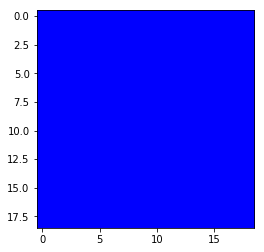

In [5]:
game.draw() 
plt.show()
for i in range(0):
    if game.game_over():
        print('Game Over')
        break
        
    result = tree_search.search()
    results.append(result)
    game.take_action(result['action'])
    
    display.clear_output(wait=True)
    print("Outcome: " + str(result['outcome']) + "  Action: " + str(result['action']))
    game.draw()    
    plt.show()

for r in results:
    print("Outcome: " + str(r['outcome']) + "  Action: " + str(r['action']))
    

# Model

In [31]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Activation, LeakyReLU, add
from keras.layers.core import Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Nadam

In [32]:
hidden_layer_count = 512

def res_block(width,inp):
    x = Conv2D(width, (3,3), padding='same')(inp)
    x = LeakyReLU(alpha=0.3)(x)
    x = Conv2D(width, (3,3), padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Conv2D(width, (3,3), padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = add([x, inp])
    x = LeakyReLU(alpha=0.3)(x)
    return BatchNormalization(axis=3)(x)
    
    

input_state= Input(shape=(shape[0],shape[1],3))
x = Conv2D(hidden_layer_count, (7,7), padding='same', activation='relu')(input_state)
x = res_block(hidden_layer_count, x)
x = res_block(hidden_layer_count, x)
x = res_block(hidden_layer_count, x)

pmx = res_block(hidden_layer_count, x)
pmx = Conv2D(1, (1,1), padding='same')(pmx)
pmx = LeakyReLU(alpha=0.3)(pmx)
pmx = Flatten()(pmx)
prob_map = Activation('softmax', name='prob_map')(pmx)

wx = res_block(hidden_layer_count, x)
wx = GlobalMaxPooling2D()(wx)
winner = Dense(1, activation='tanh', name='winner')(wx)

model = Model(input_state, [prob_map, winner])

model.compile(
    optimizer=Nadam(), 
    loss=['categorical_crossentropy', 'mean_squared_error'],
    loss_weights=[1, 2]
)

# Pre train with hand crafted model

In [8]:
def action_to_onehot(action):
    result = np.zeros(shape)
    result[action] = 1
    return result

def board_augmentation(inp, out):
    sym = random.choice([' ','|','\\'])
    if sym == '|':
        inp = np.flip(inp,axis=0)
        out = np.flip(out,axis=0)
    elif sym =='\\':
        inp = np.transpose(inp, axes=(1,0,2))
        out = np.transpose(out)

    k = random.randint(0,3)
    return np.rot90(inp,k=k, axes=(0,1)), np.rot90(out,k=k, axes=(0,1))
    
        

In [ ]:
game = Gomoku(shape)
tree_search = MonteCarloTreeSearch(game, HandCraftedGomokuModel(), 2, 4)

In [ ]:
batch_size = 64

for batch_index in range(0):
    batch_input = []
    batch_move_pred = []
    batch_win_pred = []

    for i in range(batch_size):
        if game.game_over():
            game.reset()

        result = tree_search.search()

        board, action = board_augmentation(game.get_state_for_current_player(), action_to_onehot(result['action']))
        
        batch_input.append(board)
        batch_move_pred.append(action.flatten())
        batch_win_pred.append(result['outcome'])

        game.take_action(result['action'])

        #display.clear_output(wait=True)
        #print(str(i) + " Outcome: " + str(result['outcome']) + "  Action: " + str(result['action']))
        #game.draw()    
        #plt.show()

    losses = model.train_on_batch(np.array(batch_input), [np.array(batch_move_pred), np.array(batch_win_pred)])
    print(batch_index, losses, end="\r")

# Pre train from recorded games

In [16]:
from os import listdir
from os.path import isfile, join

In [21]:
data_path = '/data/gomoku_alpha_zero/2_10'
data_files = [f for f in listdir(data_path) if isfile(join(data_path, f))]

In [22]:
train_boards = []
train_scores = []
train_actions = []

for file in data_files:
    with open(data_path+"/"+file, 'r') as f:
        board = np.stack((np.zeros(shape), np.zeros(shape),np.ones(shape)), axis=2)
        player = 0
        for line in f.readlines():
            line = line.split(',')
            
            original = np.copy(board)
            action = action_to_onehot((int(line[1]), int(line[2])))
            
            original, action = board_augmentation(original, action)
            
            train_boards.append(original)
            train_scores.append(float(line[0]))
            train_actions.append(action.flatten())
            
            board[int(line[1]), int(line[2]), player] = 1
            player = 1 - player
            
            

In [23]:
len(train_actions)

327002

In [35]:
model.fit(np.array(train_boards), [np.array(train_actions),np.array(train_scores)], shuffle=True, epochs=2, batch_size=128)

Epoch 1/2
327002/327002 [==============================] - 1745s 5ms/step - loss: 5.7878 - prob_map_loss: 2.7968 - winner_loss: 1.4955
Epoch 2/2
327002/327002 [==============================] - 1758s 5ms/step - loss: 5.7719 - prob_map_loss: 2.7809 - winner_loss: 1.4955


In [61]:
#model.save('/data/trained_models/gomoku_alpha_zero_resnet_full_model_v1.h5')
#model.save_weights('/data/trained_models/gomoku_alpha_zero_resnet_weights_v1.h5')

# Reenforment learning

In [36]:
def choice2d(pmap, count = 10):
    shape = pmap.shape
    indices = np.transpose(np.indices(shape), axes=(1,2,0)).reshape((shape[0]*shape[1],2))
    choice_indices = np.random.choice(len(indices), count, p=pmap.reshape(shape[0]*shape[1]))
    return list(map(lambda x: tuple(x), indices[choice_indices].tolist()))

class LearnedGomokuModel:
    def __init__(self, model):
        self.model = model
    
    def predicted_outcome(self, game):
        pred = model.predict(np.array([game.get_state_for_current_player()]))
        return pred[1][0][0]

    def most_probable_actions(self, game, max_branching):
        return list(set(choice2d(self.get_probability_map(game), max_branching)))
    
    def get_probability_map(self, game):
        pred = model.predict(np.array([game.get_state_for_current_player()]))
        pmap = np.multiply(pred[0][0].reshape(game.get_shape()), 1-game.get_occupied())
        return pmap / np.sum(pmap) 

In [59]:
game = Gomoku(shape)
lmodel = LearnedGomokuModel(model)
tree_search = MonteCarloTreeSearch(game, LearnedGomokuModel(model), 3, 10)
results = []

Outcome: 1/-1.0  Action: (10, 9)


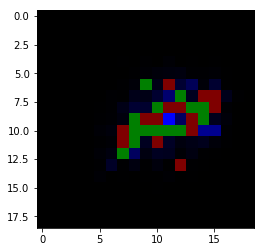

Outcome: -1  Action: (9, 9)
Outcome: -1  Action: (10, 8)
Outcome: -1  Action: (9, 10)
Outcome: -1  Action: (10, 11)
Outcome: -1  Action: (11, 10)
Outcome: -1  Action: (10, 10)
Outcome: -1  Action: (10, 7)
Outcome: -1  Action: (11, 8)
Outcome: -1  Action: (8, 11)
Outcome: -1  Action: (12, 7)
Outcome: -1  Action: (8, 12)
Outcome: -1  Action: (9, 8)
Outcome: -1  Action: (9, 13)
Outcome: -1  Action: (8, 13)
Outcome: -1  Action: (7, 14)
Outcome: -1  Action: (6, 9)
Outcome: -1  Action: (7, 15)
Outcome: -1  Action: (8, 14)
Outcome: -1  Action: (10, 13)
Outcome: -1  Action: (7, 12)
Outcome: -1  Action: (13, 12)
Outcome: -1  Action: (9, 14)
Outcome: -1  Action: (6, 11)
Outcome: -1  Action: (8, 10)
Outcome: -1  Action: (11, 7)
Outcome: -1  Action: (10, 12)
Outcome: -1  Action: (8, 15)
Outcome: 1  Action: (10, 9)


In [60]:
while not game.game_over():
    result = tree_search.search()
    results.append(result)
    game.take_action(result['action'])
    predicted_outcome = lmodel.predicted_outcome(game)
    
    display.clear_output(wait=True)
    print("Outcome: " + str(result['outcome']) + "/" + str(predicted_outcome) + "  Action: " + str(result['action']))
    pmap = lmodel.get_probability_map(game)
    board = game.get_state()
    plt.imshow(np.stack([board[:,:,0], board[:,:,1], pmap/np.max(pmap)], axis = 2))
    plt.show()
    

for r in results:
    print("Outcome: " + str(r['outcome']) + "  Action: " + str(r['action']))
    

-1.0


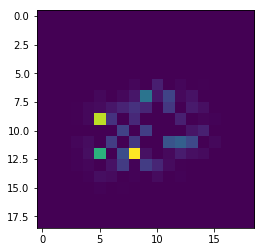

In [40]:
lmodel = LearnedGomokuModel(model)
#lmodel = HandCraftedGomokuModel()
print(lmodel.predicted_outcome(game))
plt.imshow(lmodel.get_probability_map(game))